In [1]:
import spacy
import json
import random
import re
import pandas as pd
import numpy as np
from copy import deepcopy
from sklearn import model_selection
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
from spacy.symbols import ORTH
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
import matplotlib.pyplot as plt

## Some boilerplate code for nicer looking confusion matrices


abridged from [scikit-learn example code](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html)

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## Some helper code to analyze TFIDF data

Credit for code goes to [buhrmann.github.io](https://buhrmann.github.io/tfidf-analysis.html)

In [3]:
def top_tfidf_features(row, features, top_n=15):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df


def top_features_in_doc(Xtr, features, row_id, top_n=15):
    ''' Top tfidf features in specific document (matrix row) '''
    xtr_row = Xtr[row_id]
    if type(xtr_row) is not np.ndarray:
        xtr_row = xtr_row.toarray()
    row = np.squeeze(xtr_row)
    return top_tfidf_features(row, features, top_n)


def top_mean_features(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids]
    else:
        D = Xtr
    if type(D) is not np.ndarray:
        D = D.toarray()
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_features(tfidf_means, features, top_n)


def top_features_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = {}
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_features(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs[label] = feats_df
    return dfs


def span_top_tfidf(spans_txt, spans_tfidf, features, index):
    print('span text:\n'+spans_txt[index]+'\n')
    print(top_features_in_doc(spans_tfidf, features, index))

# Load Data

In [4]:
corpus_fpath = '../labeled/ldsi_w21_curated_annotations_v2.json'
data = json.load(open(corpus_fpath))

In [36]:
data.keys()

dict_keys(['documents', 'annotations', 'types'])

In [37]:
data['annotations'][0]

{'_id': '61bb066d97ad59b4cfc4699a',
 'start': 15922,
 'end': 16078,
 'document': '61aea57397ad59b4cfc41399',
 'type': '61aeaf8097ad59b4cfc416d7'}

In [38]:
data['documents'][0]['_id']

'61aea55c97ad59b4cfc4128c'

In [39]:
len(data['documents'])

540

In [40]:
data['documents'][0].keys()

dict_keys(['_id', 'name', 'plainText', 'outcome'])

In [41]:
data['documents'][0]['_id']

'61aea55c97ad59b4cfc4128c'

Define some convenience shorthands and dictionaries:

In [5]:
annotations = data['annotations']
documents_by_id = {d['_id']: d for d in data['documents']}
types_by_id = {t['_id']: t for t in data['types']}
type_ids_by_name = {t['name']: t['_id'] for t in data['types']}
type_names_by_id = {t['_id']: t['name'] for t in data['types']}
doc_id_by_name = {d['name']: d['_id'] for d in data['documents']}
doc_name_by_id = {d['_id']: d['name'] for d in data['documents']}

# Data Structures

Examine data structures so we know how to work with them

In [19]:
annotations[0]

{'_id': '61bb066d97ad59b4cfc4699a',
 'start': 15922,
 'end': 16078,
 'document': '61aea57397ad59b4cfc41399',
 'type': '61aeaf8097ad59b4cfc416d7'}

In [20]:
list(types_by_id.items())[0]

('61aeaf8097ad59b4cfc416d7',
 {'_id': '61aeaf8097ad59b4cfc416d7',
  'name': 'CaseFooter',
  'isA': '58781cf945f90f3bfc5cba7d',
  'attributes': []})

In [21]:
list(documents_by_id.items())[0]

('61aea55c97ad59b4cfc4128c',
 {'_id': '61aea55c97ad59b4cfc4128c',
  'name': '0601461.txt',
  'plainText': 'Citation Nr: 0601461\t\r\nDecision Date: 01/18/06    Archive Date: 01/31/06\r\n\r\nDOCKET NO.  04-17 231\t)\tDATE\r\n\t)\r\n\t)\r\n\r\nOn appeal from the\r\nDepartment of Veterans Affairs Regional Office in No. Little \r\nRock, Arkansas\r\n\r\n\r\nTHE ISSUE\r\n\r\nEntitlement to service connection for hepatitis C.\r\n\r\n\r\nREPRESENTATION\r\n\r\nAppellant represented by:\tThe American Legion\r\n\r\n\r\nWITNESS AT HEARING ON APPEAL\r\n\r\nAppellant\r\n\r\n\r\nATTORNEY FOR THE BOARD\r\n\r\nP. Olson, Associate Counsel\r\n\r\n\r\nINTRODUCTION\r\n\r\nThe veteran had active military service from May 1971 to July \r\n1976.\r\n\r\nThis matter comes before the Board of Veterans\' Appeals \r\n(Board or BVA) on appeal from a July 2003 rating decision of \r\nthe Department of Veterans Affairs (VA) Regional Office (RO) \r\nin N. Little Rock, Arkansas.\r\n\r\nIn August 2004, the veteran testif

# Very Basic Data Survey

In [ ]:
len(documents_by_id)

In [44]:
len(annotations)

15349

In [ ]:
doc_lengths = [len(d['plainText']) for d in documents_by_id.values()]
plt.hist(doc_lengths, bins=50)
plt.show()

In [ ]:
doc_num_annos = [len([a for a in annotations if a['document'] == doc_id])
                 for doc_id in documents_by_id]
doc_num_annos = [n for n in doc_num_annos if n > 0]
plt.hist(doc_num_annos, bins=100)
plt.show()

# Create Corpus

In [6]:
# get all sentences assuming every annotation is a sentence
def make_span_data(documents_by_id, types_by_id, annotations):
    span_data = []
    for a in annotations:
        start = a['start']
        end = a['end']
        document_txt = documents_by_id[a['document']]['plainText']
        atype = a['type']
        sd = {'txt': document_txt[start:end],
              'document': a['document'],
              'type': types_by_id[atype]['name'],
              'start': a['start'],
              'start_normalized': a['start'] / len(document_txt),
              'end': a['end']}
        span_data.append(sd)
    return span_data

In [7]:
spans = make_span_data(documents_by_id, types_by_id, annotations)
span_labels = [s['type'] for s in spans]

Sample train and test set while stratifying across types

In [8]:
train_spans, test_spans = model_selection.train_test_split(spans,
                                                           test_size=.2,
                                                           random_state=42,
                                                           stratify=span_labels)
train_spans_txt = [s['txt'] for s in train_spans]
test_spans_txt = [s['txt'] for s in test_spans]

In [9]:
print(len(train_spans))
print(len(test_spans))

12279
3070


In [10]:
train_spans[0]

{'txt': 'Eddy v. Brown, 9 \r\nVet. App. 52 (1996). ',
 'document': '61aea57097ad59b4cfc4135b',
 'type': 'Citation',
 'start': 6722,
 'start_normalized': 0.6137131379530723,
 'end': 6762}

In [11]:
train_spans_txt[0]

'Eddy v. Brown, 9 \r\nVet. App. 52 (1996). '

In [12]:
print(f'train: {len(train_spans)}; test: {len(test_spans)}')

train: 12279; test: 3070


In [13]:
random.choice(train_spans)

{'txt': 'See Hensley, supra.',
 'document': '61aea57397ad59b4cfc413a5',
 'type': 'Citation',
 'start': 14639,
 'start_normalized': 0.6135887333389219,
 'end': 14658}

# Some Tough Examples

In [16]:
example_basic_1 = 'In sum, as the preponderance of the evidence is against the Veteran\'s claim, his appeal must be denied.'
example_cit_1 = 'Smith v. Gober, 14 Vet. App. 227 (2000), aff\'d 281 F.3d 1384 (Fed. Cir. 2002); Dela Cruz v. Principi, 15 Vet. App. 143 (2001); see also Quartuccio v. Principi, 16 Vet. App. 183 (2002).'
example_rule_1 = '"To establish a right to compensation for a present disability, a Veteran must show: "(1) the existence of a present disability; (2) in-service incurrence or aggravation of a disease or injury; and (3) a causal relationship between the present disability and the disease or injury incurred or aggravated during service"-the so-called "nexus" requirement."'
example_mixed_1 = 'In Dingess v. Nicholson, 19 Vet. App. 473 (2006), the U.S. Court of Appeals for Veterans Claims held that, upon receipt of an application for a service-connection claim, 38 U.S.C.A. � 5103(a) and 38 C.F.R. � 3.159(b) require VA to provide the claimant with notice that a disability rating and an effective date for the award of benefits will be assigned if service connection is awarded. '

# Manual Tokenization Example

In [10]:
def tokenize(txt):
    dirty_tokens = re.split(' +', txt)  # split words
    # remove all non-alphanumerics
    clean_tokens = [re.sub(r'\W', '', t).lower() 
                    for t in dirty_tokens]
    if '' in clean_tokens:  # remove empty tokens
        clean_tokens.remove('')
    return clean_tokens


def tokenize_spans(spans):
    for s in spans:
        s['tokens_manual'] = tokenize(s['txt'])
        
        
def build_vocabulary(spans):
    vocab_counts = {}
    for sd in spans:
        for t in tokenize(sd['txt']):
            if t in vocab_counts:
                vocab_counts[t] += 1
            else:
                vocab_counts[t] = 1
    return vocab_counts

We can use this basic tokenizer to do some surface statistics

In [67]:
tokenize(example_basic_1)

['in',
 'sum',
 'as',
 'the',
 'preponderance',
 'of',
 'the',
 'evidence',
 'is',
 'against',
 'the',
 'veterans',
 'claim',
 'his',
 'appeal',
 'must',
 'be',
 'denied']

In [68]:
tokenize_spans(train_spans)

In [11]:
vocab_counts_manual = build_vocabulary(train_spans)
unique_tokens_manual = [token for token, count in vocab_counts_manual.items() 
                        if count == 1]

In [70]:
print(len(vocab_counts_manual))
print(vocab_counts_manual['veteran'])
print(len(unique_tokens_manual))

9163
2887
3767


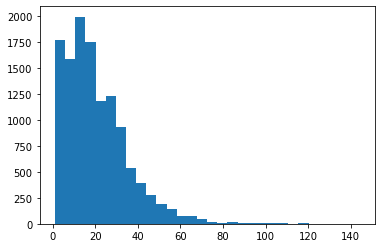

In [71]:
span_lengths_manual = [len(s['tokens_manual']) for s in train_spans]
plt.hist(span_lengths_manual, bins=30)
plt.show()

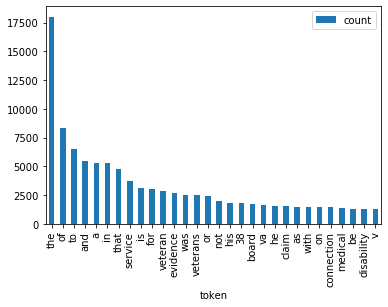

In [72]:
vocab_df = pd.DataFrame([{'token': t, 'count': c} for t, c in vocab_counts_manual.items()])
vocab_df = vocab_df.set_index(['token'])
vocab_df.sort_values('count', ascending=False)[:30].plot.bar()
plt.show()

In [12]:
min_freq = 6
max_freq = 100
feature_names_manual = sorted(token for token, count in vocab_counts_manual.items() 
                       if min_freq <= count <= max_freq)
print(f'number of thresholded with {min_freq} < n < {max_freq}: {len(feature_names_manual)}')

number of thresholded with 6 < n < 100: 2340


# Basic TFIDF vectorization with sklearn

We are using sklear's [TFIDF vectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer.fit) here, because it is faster than doing it all by ourselves and has useful default parameters

In [13]:
vectorizer = TfidfVectorizer(min_df=5)
vectorizer = vectorizer.fit(train_spans_txt)
tfidf_features_skl = vectorizer.get_feature_names()

/home/mahaut/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
train_tfidf_skl = vectorizer.transform(train_spans_txt).toarray()
test_tfidf_skl = vectorizer.transform(test_spans_txt).toarray()
train_spans_labels = np.array([s['type'] for s in train_spans])
test_spans_labels = np.array([s['type'] for s in test_spans])

... and we get numpy arrays

In [15]:
train_tfidf_skl.shape

(12279, 2924)

Examine the top TFIDF values of tokens in a sentence

In [16]:
span_top_tfidf(train_spans_txt, 
               train_tfidf_skl,
               tfidf_features_skl,
               random.randint(0, len(train_spans)))

span text:
38 C.F.R. � 3.311(b).

       feature     tfidf
0          311  0.916395
1           38  0.400275
2         zone  0.000000
3       dental  0.000000
4    depressed  0.000000
5        depot  0.000000
6   deployment  0.000000
7    depending  0.000000
8   dependence  0.000000
9   department  0.000000
10     denying  0.000000
11        deny  0.000000
12      denied  0.000000
13      degree  0.000000
14      denial  0.000000


Examine features with highest average TFIDF score per class

In [17]:
dfs = top_features_by_class(train_tfidf_skl, 
                            train_spans_labels,
                            tfidf_features_skl)

In [18]:
dfs.keys()

dict_keys(['CaseFooter', 'CaseHeader', 'CaseIssue', 'Citation', 'ConclusionOfLaw', 'Evidence', 'EvidenceBasedOrIntermediateFinding', 'EvidenceBasedReasoning', 'Header', 'LegalRule', 'LegislationAndPolicy', 'PolicyBasedReasoning', 'Procedure', 'RemandInstructions'])

In [19]:
dfs['Citation']

,feature,tfidf
0,38,0.216148
1,app,0.093719
2,vet,0.093714
3,see,0.092496
4,303,0.084768
5,west,0.052288
6,159,0.040536
7,2002,0.039141
8,1110,0.038355
9,brown,0.038191


## Train & Evaluate Model

Models:  
[Gaussian Naive Bayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)  
[Support Vector Machine Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)  
[Decision Tree](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)  
[Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

In [ ]:
#clf = SVC(gamma='auto')
#clf = RandomForestClassifier(n_estimators=100, max_depth=12)
#clf = tree.DecisionTreeClassifier(max_depth=8)
clf_skl = GaussianNB()
clf_skl = clf_skl.fit(train_tfidf_skl, train_spans_labels)

In [ ]:
print('TRAIN:\n'+classification_report(train_spans_labels, 
                                       clf_skl.predict(train_tfidf_skl)))
print('TEST:\n'+classification_report(test_spans_labels,
                                      clf_skl.predict(test_tfidf_skl)))

# Build Feature Vector using Spacy
More information: [Spacy](https://spacy.io)

## Tokenization

In [20]:
# basic English pipeline provided by spacy
nlp = spacy.load("en_core_web_sm")

In [21]:
example_fact_1 = "He related that he was \"having a reoccurrence of bronchitis [symptoms].\""

More information on customizing tokenizers [at the Spacy docs](https://spacy.io/usage/linguistic-features#tokenization)  
Note that you may not alter the text, but you can use it to suppress or force tokenization.

In [22]:
from spacy.attrs import ORTH
nlp.tokenizer.add_special_case('Vet. App.', [{ORTH: 'Vet. App.'}])

In [23]:
ruler = nlp.get_pipe("attribute_ruler")
patterns = [[{"TEXT": "["}]]
attrs = {"POS": "PUNCT"}
ruler.add(patterns=patterns, attrs=attrs, index=0)

In [24]:
#test_txt = example_basic_1
#test_txt = example_cit_1
#test_txt = example_fact_1
test_txt = example_mixed_1
#test_txt = 'today (not tomorrow) is a big day'
print(test_txt)
doc = nlp(test_txt)
print(f'{len(list(doc.sents))} sentences:')
print('===')
for sent in doc.sents:
    print(sent)
print('===')
for t in doc:
    print(f'{t.text} | {t.lemma_} | {t.pos_}')

NameError: name 'example_mixed_1' is not defined

In [25]:
def spacy_tokenize(txt):
    doc = nlp(txt)
    tokens = list(doc)
    clean_tokens = []
    par_removed = ''
    for t in tokens:
        if t.pos_ == 'PUNCT':
            pass
        elif t.pos_ == 'NUM':
            clean_tokens.append(f'<NUM{len(t)}>')
        elif t.lemma_ == "'s":
            pass
        elif t.lemma_ == "'" or t.lemma_ == "\n" or t.lemma_ == "\r" or t.lemma_ == "\t":
            pass
        elif '(' in t.lemma_:
            par_split = t.lemma_.split('(')
            for elem in par_split:
                par_removed = par_removed + elem
            par_split = spacy_tokenize(par_removed)
            for elem in par_split:
                clean_tokens.append(elem)
        elif "\n" in t.lemma_:
            par_split = t.lemma_.split('\n')
            for elem in par_split:
                if elem != ' ' and elem != '':
                    par_removed = par_removed + ' ' + elem
            par_split = spacy_tokenize(par_removed)
            for elem in par_split:
                clean_tokens.append(elem)
        else:
            clean_tokens.append(t.lemma_.lower())
    return clean_tokens

def spans_add_spacy_tokens(spans):
    for s in spans:
        s['tokens_spacy'] = spacy_tokenize(s['txt'])

In [80]:
#tokenize(example_cit_1)
example_seg_1 = "Acting Veterans Law Judge, Board of Veterans' Appeals\n\nUnder 38 U.S.C.A. \u00a7 7252, only \ntoday a decision of the Board is appealable to the Court."

In [81]:
text = example_seg_1
print(text)
print(spacy_tokenize(text), len(spacy_tokenize(text)))

Acting Veterans Law Judge, Board of Veterans' Appeals

Under 38 U.S.C.A. § 7252, only 
today a decision of the Board is appealable to the Court.
['acting', 'veterans', 'law', 'judge', 'board', 'of', 'veterans', 'appeal', 'under', '<NUM2>', 'u.s.c.a.', '§', '<NUM4>', 'only', 'today', 'a', 'decision', 'of', 'the', 'board', 'be', 'appealable', 'to', 'the', 'court'] 25


In [26]:
# will take a moment
spans_add_spacy_tokens(train_spans)
spans_add_spacy_tokens(test_spans)

In [27]:
random.choice(train_spans)

{'txt': 'Legal Criteria\r',
 'document': '61aea55f97ad59b4cfc41337',
 'type': 'Header',
 'start': 4547,
 'start_normalized': 0.26813303455596177,
 'end': 4562,
 'tokens_spacy': ['legal', 'criteria']}

## Vectorization

In [28]:
# suboptimal: tokenizer gets called twice
spacy_tfidf_vectorizer = TfidfVectorizer(tokenizer=spacy_tokenize,
                                         min_df=3,
                                         ngram_range=(1,1))
spacy_tfidf_vectorizer = spacy_tfidf_vectorizer.fit(train_spans_txt)
tfidf_features_spacy = spacy_tfidf_vectorizer.get_feature_names()

/home/mahaut/.local/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/home/mahaut/.local/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [40]:
from statistics import mean
print(train_spans[110]['tokens_spacy'])
print(len(train_spans[110]['tokens_spacy']))
list_nb_of_tokens = []
for elem in train_spans:
    list_nb_of_tokens.append(len(elem['tokens_spacy']))
mean_nb_tokens = mean(list_nb_of_tokens)
std_nb_tokens = np.std(np.array(list_nb_of_tokens))
print("mean: ", mean_nb_tokens, " / std: ", std_nb_tokens)

['the', 'board', 'be', 'cognizant', 'that', '<NUM3>', 'of', 'the', 'most', 'recent', 'correspondence', 'with', 'the', 'veteran', 'a', 'notification', 'from', 'the', 'board', 'date', 'in', 'july', '<NUM4>', 'and', 'a', 'copy', 'of', 'the', 'december', '<NUM4>', 'ssoc', 'from', 'the', 'amc', 'have', 'be', 'return', 'to', 'the', 'respective', 'agency', 'as', 'undeliverable']
43
mean:  22.54703151722453  / std:  16.484338442948992


### Small walkthrough of how to extend/compose feature vectors

In [42]:
# numpy feature vector extension
train_tfidf_spacy = spacy_tfidf_vectorizer.transform(train_spans_txt).toarray()
print(train_tfidf_spacy.shape)
train_starts_normalized = np.array([s['start_normalized'] for s in train_spans])
print(train_starts_normalized.shape)
print(np.expand_dims(train_starts_normalized, axis=1).shape)
ext = np.concatenate((train_tfidf_spacy, 
                      np.expand_dims(train_starts_normalized, axis=1)), axis=1)
print(ext.shape)
train_nb_tokens_normalized = np.array([(len(s['tokens_spacy'])-mean_nb_tokens)/std_nb_tokens for s in train_spans])
print(train_nb_tokens_normalized.shape)
print(np.expand_dims(train_nb_tokens_normalized, axis=1).shape)
ext2 = np.concatenate((ext, 
                      np.expand_dims(train_nb_tokens_normalized, axis=1)), axis=1)
print(ext2.shape)

(12279, 3126)
(12279,)
(12279, 1)
(12279, 3127)
(12279,)
(12279, 1)
(12279, 3128)


### Examine highest average TFIDF features by class

In [ ]:
dfs = top_features_by_class(train_tfidf_spacy, train_spans_labels, tfidf_features_spacy)

In [ ]:
dfs['Citation']

In [ ]:
def make_feature_vectors_and_labels(spans, vectorizer):
    # function takes long to execute
    # note: we un-sparse the matrix here to be able to manipulate it
    tfidf = spacy_tfidf_vectorizer.transform([s['txt'] for s in spans]).toarray()
    starts_normalized = np.array([s['start_normalized'] for s in spans])
    num_tokens = np.array([len(s['tokens_spacy']) for s in spans])
    y = np.array([s['type'] for s in spans])
    X = np.concatenate((tfidf, np.expand_dims(starts_normalized, axis=1)), axis=1)
    return X, y

In [ ]:
train_X, train_y = make_feature_vectors_and_labels(train_spans, spacy_tfidf_vectorizer)
test_X, test_y = make_feature_vectors_and_labels(test_spans, spacy_tfidf_vectorizer)

In [ ]:
print(f'{train_X.shape} {train_y.shape}')
print(f'{test_X.shape} {test_y.shape}')

In [ ]:
#clf = GaussianNB()
clf = tree.DecisionTreeClassifier(max_depth=12)
clf = clf.fit(train_X, train_y)

In [ ]:
print('TRAIN:\n'+classification_report(train_spans_labels, clf.predict(train_X)))
print('TEST:\n'+classification_report(test_spans_labels, clf.predict(test_X)))

In [ ]:
plot_confusion_matrix(test_spans_labels, clf.predict(test_X), classes=list(clf.classes_),
                      title='Confusion matrix for training data')
plt.show()

In [ ]:
type_names_by_id

In [ ]:
def prediction_errors(clf, eval_spans, vectorizer, 
                      select_true_label=None, 
                      select_pred_label=None):
    eval_X, eval_y = make_feature_vectors_and_labels(eval_spans, vectorizer)
    eval_spans_txt = [s['txt'] for s in eval_spans]
    eval_spans_labels = [s['type'] for s in eval_spans]
    pred_y = clf.predict(eval_X)
    for i in range(len(eval_spans)):
        true_label = eval_spans_labels[i]
        pred_label = pred_y[i]
        if true_label != pred_label:
            if select_true_label and true_label != select_true_label: continue
            if select_pred_label and pred_label != select_pred_label: continue
            doc_name = documents_by_id[eval_spans[i]['document']]['name']
            print('sentence # '+str(i)+' / case '+doc_name+' / @'+str(eval_spans[i]['start']))
            print('pred: '+pred_label+' / true: '+true_label)
            print(eval_spans[i]['txt'])
            print()

In [ ]:
prediction_errors(clf,
                  random.sample(train_spans, 100),
                  spacy_tfidf_vectorizer,
                  select_pred_label='Evidence')